# RNN(Vanilla RNN, LSTM, GRU)를 사용하여 MNIST 분류기 만들기

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as  plt
from tqdm.notebook import tqdm
import os
import gc

import torch
import torchvision
import torchvision.transforms as T
from torchsummary import summary

from sklearn.metrics import accuracy_score
import tensorflow as tf

import wandb

In [2]:
# seed 고정
import random
import torch.backends.cudnn as cudnn

def random_seed(seed_num):
    torch.manual_seed(seed_num)
    torch.cuda.manual_seed(seed_num)
    torch.cuda.manual_seed_all(seed_num)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(seed_num)

random_seed(42)

In [3]:
device = torch.device('mps')

In [37]:
wandb.login(key='2a6ed9b82b10f4c201952cf2948e01f8a0b197ab')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: greedjar74 (greedjar7498). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/kimhongseok/.netrc


True

# data

In [4]:
mnist = tf.keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [5]:
type(train_images[0])

numpy.ndarray

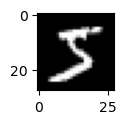

In [10]:
plt.figure(figsize=(1, 1))
plt.imshow(train_images[0], cmap='gray')

## Custom Dataset

In [11]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transforms):
        super().__init__()
        self.data = list((transforms(image), label) for image, label in zip(images, labels))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [12]:
transforms = T.Compose([
    T.ToTensor()
])

train_dataset = CustomDataset(train_images, train_labels, transforms)
test_dataset = CustomDataset(test_images, test_labels, transforms)

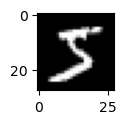

In [15]:
plt.figure(figsize=(1, 1))
plt.imshow(train_dataset[0][0].squeeze(), cmap='gray')

In [16]:
total_num = len(train_dataset)
train_num, valid_num = int(total_num*0.8), int(total_num*0.2)

train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_num, valid_num])

print(f'Train data: {len(train_dataset)}, Valid data: {len(valid_dataset)}, Test data: {len(test_dataset)}')

Train data: 48000, Valid data: 12000, Test data: 10000


In [18]:
batch_size = 1000

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
for images, labels in train_dataloader:
    print(images.shape)
    print(labels)
    break

torch.Size([1000, 1, 28, 28])
tensor([5, 8, 4, 4, 4, 0, 3, 9, 1, 3, 6, 2, 1, 3, 5, 7, 4, 6, 0, 4, 8, 4, 0, 4,
        3, 3, 4, 3, 2, 4, 2, 6, 0, 2, 8, 9, 9, 6, 8, 1, 3, 1, 8, 1, 3, 2, 9, 9,
        5, 8, 3, 0, 5, 7, 1, 1, 5, 7, 5, 6, 1, 3, 1, 4, 2, 0, 5, 6, 8, 7, 7, 1,
        2, 1, 8, 3, 1, 7, 1, 4, 6, 6, 4, 0, 2, 4, 6, 3, 8, 7, 3, 9, 4, 2, 2, 1,
        9, 9, 6, 2, 1, 1, 4, 9, 8, 3, 8, 0, 5, 8, 5, 0, 3, 8, 2, 4, 9, 8, 5, 8,
        8, 2, 4, 7, 8, 4, 5, 8, 4, 0, 8, 8, 2, 1, 3, 8, 3, 5, 5, 4, 5, 4, 7, 6,
        0, 7, 6, 2, 5, 4, 2, 9, 8, 2, 7, 5, 8, 7, 7, 3, 6, 5, 1, 4, 8, 7, 7, 3,
        1, 3, 6, 2, 0, 0, 8, 5, 3, 7, 8, 3, 2, 0, 0, 0, 5, 4, 1, 7, 2, 2, 1, 1,
        9, 5, 7, 5, 3, 2, 2, 7, 1, 9, 7, 7, 2, 7, 3, 4, 3, 1, 8, 1, 1, 0, 1, 3,
        1, 1, 3, 9, 5, 1, 8, 6, 3, 8, 3, 6, 0, 7, 9, 2, 9, 2, 4, 8, 7, 7, 2, 6,
        7, 3, 7, 7, 5, 4, 2, 6, 5, 0, 4, 4, 0, 4, 3, 2, 6, 5, 5, 2, 1, 9, 9, 7,
        2, 9, 6, 5, 1, 1, 1, 2, 8, 0, 9, 3, 9, 1, 9, 6, 0, 6, 4, 3, 5, 7, 2, 4,
        0,

In [29]:
for images, labels in train_dataloader:
    print(images.squeeze().shape)
    print(labels)
    break

torch.Size([1000, 28, 28])
tensor([7, 3, 4, 7, 3, 8, 4, 3, 8, 6, 0, 6, 9, 5, 6, 2, 3, 6, 3, 1, 8, 0, 5, 8,
        2, 2, 5, 6, 8, 6, 1, 4, 1, 5, 9, 0, 3, 9, 8, 1, 0, 0, 7, 2, 6, 5, 0, 9,
        7, 2, 8, 1, 1, 4, 3, 1, 3, 7, 1, 0, 0, 8, 3, 4, 3, 5, 0, 2, 4, 1, 5, 8,
        5, 6, 9, 8, 6, 9, 5, 9, 5, 1, 7, 6, 0, 3, 7, 3, 8, 4, 5, 3, 9, 7, 0, 8,
        1, 5, 1, 2, 9, 2, 3, 2, 9, 7, 0, 3, 9, 9, 0, 8, 1, 6, 3, 5, 6, 9, 1, 4,
        6, 0, 8, 8, 8, 3, 5, 9, 8, 8, 1, 7, 1, 7, 4, 9, 8, 2, 7, 5, 4, 8, 6, 4,
        9, 8, 0, 0, 0, 2, 6, 2, 1, 2, 1, 9, 8, 3, 4, 4, 1, 3, 2, 6, 5, 7, 7, 3,
        1, 8, 9, 3, 4, 6, 4, 8, 4, 9, 3, 9, 3, 8, 0, 9, 2, 1, 8, 8, 7, 8, 1, 1,
        9, 4, 1, 7, 8, 8, 4, 1, 7, 5, 4, 9, 2, 6, 4, 1, 7, 8, 6, 6, 8, 1, 1, 9,
        4, 2, 9, 2, 6, 3, 8, 6, 3, 5, 1, 2, 0, 5, 5, 3, 7, 1, 4, 0, 1, 3, 8, 3,
        7, 0, 2, 6, 7, 6, 7, 1, 8, 2, 1, 8, 3, 0, 9, 3, 5, 6, 1, 0, 6, 3, 7, 9,
        3, 5, 9, 0, 6, 7, 7, 3, 8, 9, 4, 4, 1, 1, 7, 5, 9, 9, 7, 1, 2, 7, 4, 1,
        4, 2,

# RNN Model

In [33]:
class mnist_RNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.rnn = torch.nn.RNN(28, 128, batch_first=True)
        self.fc = torch.nn.Linear(128, 10)
        self.softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.squeeze()
        outputs, h_0 = self.rnn(x)
        outputs = self.fc(h_0.squeeze())
        outputs = self.softmax(outputs)
        
        return outputs

# train

In [39]:
def training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        train_accuracy += (labels == predicted).sum().item()

        tbar.set_description(f'Epoch/Epochs: [{epoch+1}/{num_epochs}] Train Loss: {loss.item():.4f}')

    train_loss = train_loss / len(train_dataloader)
    train_accuracy = train_accuracy / len(train_dataset)

    return model, train_loss, train_accuracy

def evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            max_prob, predicted = torch.max(outputs, 1)
            valid_accuracy += (predicted == labels).sum().item()

            tbar.set_description(f'Epoch/Epochs: [{epoch+1}/{num_epochs}] Valid Loss: {loss.item():.4f}')

    valid_loss = valid_loss / len(valid_dataloader)
    valid_accuracy = valid_accuracy / len(valid_dataset)

    return model, valid_loss, valid_accuracy

def training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, num_epochs, run):
    model.to(device)
    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs)

        monitoring = {'Train Loss':train_loss, 'Train Accuracy':train_accuracy, 'Valid Loss':valid_loss, 'Valid Accuracy':valid_accuracy}
        run.log(monitoring, step=epoch)

        print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Valid Loss: {valid_loss}, Valid Accuracy: {valid_accuracy}')

    return model

In [40]:
run_vanilla_rnn = wandb.init(project='DL_mission_middle_2', name='vanilla_rnn_training')
model = mnist_RNN()

criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, 15, run_vanilla_rnn)
run_vanilla_rnn.finish()

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 1.7264966766039531, Train Accuracy: 0.40227083333333336, Valid Loss: 1.2986939748128254, Valid Accuracy: 0.5465833333333333


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 1.1529332225521405, Train Accuracy: 0.5953125, Valid Loss: 1.0490704774856567, Valid Accuracy: 0.63325


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.9097320611278216, Train Accuracy: 0.6864166666666667, Valid Loss: 0.8265765408674876, Valid Accuracy: 0.7280833333333333


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.7429822323222955, Train Accuracy: 0.7529791666666666, Valid Loss: 0.6977052440245947, Valid Accuracy: 0.773


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.6364752799272537, Train Accuracy: 0.795, Valid Loss: 0.604251354932785, Valid Accuracy: 0.8079166666666666


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.5267949545135101, Train Accuracy: 0.8360833333333333, Valid Loss: 0.501994843284289, Valid Accuracy: 0.8448333333333333


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.473714600627621, Train Accuracy: 0.8520833333333333, Valid Loss: 0.45521469165881473, Valid Accuracy: 0.86325


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.4207573936631282, Train Accuracy: 0.8716041666666666, Valid Loss: 0.4489947979648908, Valid Accuracy: 0.8654166666666666


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.38162326750655967, Train Accuracy: 0.884625, Valid Loss: 0.37962450832128525, Valid Accuracy: 0.8881666666666667


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.3566052932292223, Train Accuracy: 0.8929375, Valid Loss: 0.3624284341931343, Valid Accuracy: 0.8975833333333333


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.32867116294801235, Train Accuracy: 0.9022291666666666, Valid Loss: 0.347105676929156, Valid Accuracy: 0.8986666666666666


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.3025879630198081, Train Accuracy: 0.9109583333333333, Valid Loss: 0.3067381891111533, Valid Accuracy: 0.91225


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.2832823529218634, Train Accuracy: 0.91625, Valid Loss: 0.30221010868748027, Valid Accuracy: 0.9129166666666667


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.265293021996816, Train Accuracy: 0.9218541666666666, Valid Loss: 0.2868014872074127, Valid Accuracy: 0.9174166666666667


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.26009257324039936, Train Accuracy: 0.9224583333333334, Valid Loss: 0.2690180353820324, Valid Accuracy: 0.9225833333333333


# test

In [43]:
model.eval()
test_loss = 0.0
test_accuracy = 0

total_labels = []
total_images = []
total_pred = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        test_accuracy += (predicted == labels).sum().item()

        total_labels.extend(labels.cpu())
        total_images.extend(images.cpu())
        total_pred.extend(predicted.cpu())

test_loss = test_loss / len(test_dataloader)
test_accuracy = test_accuracy / len(test_dataset)

print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

  0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 0.24559555500745772, Test Accuracy: 0.9278


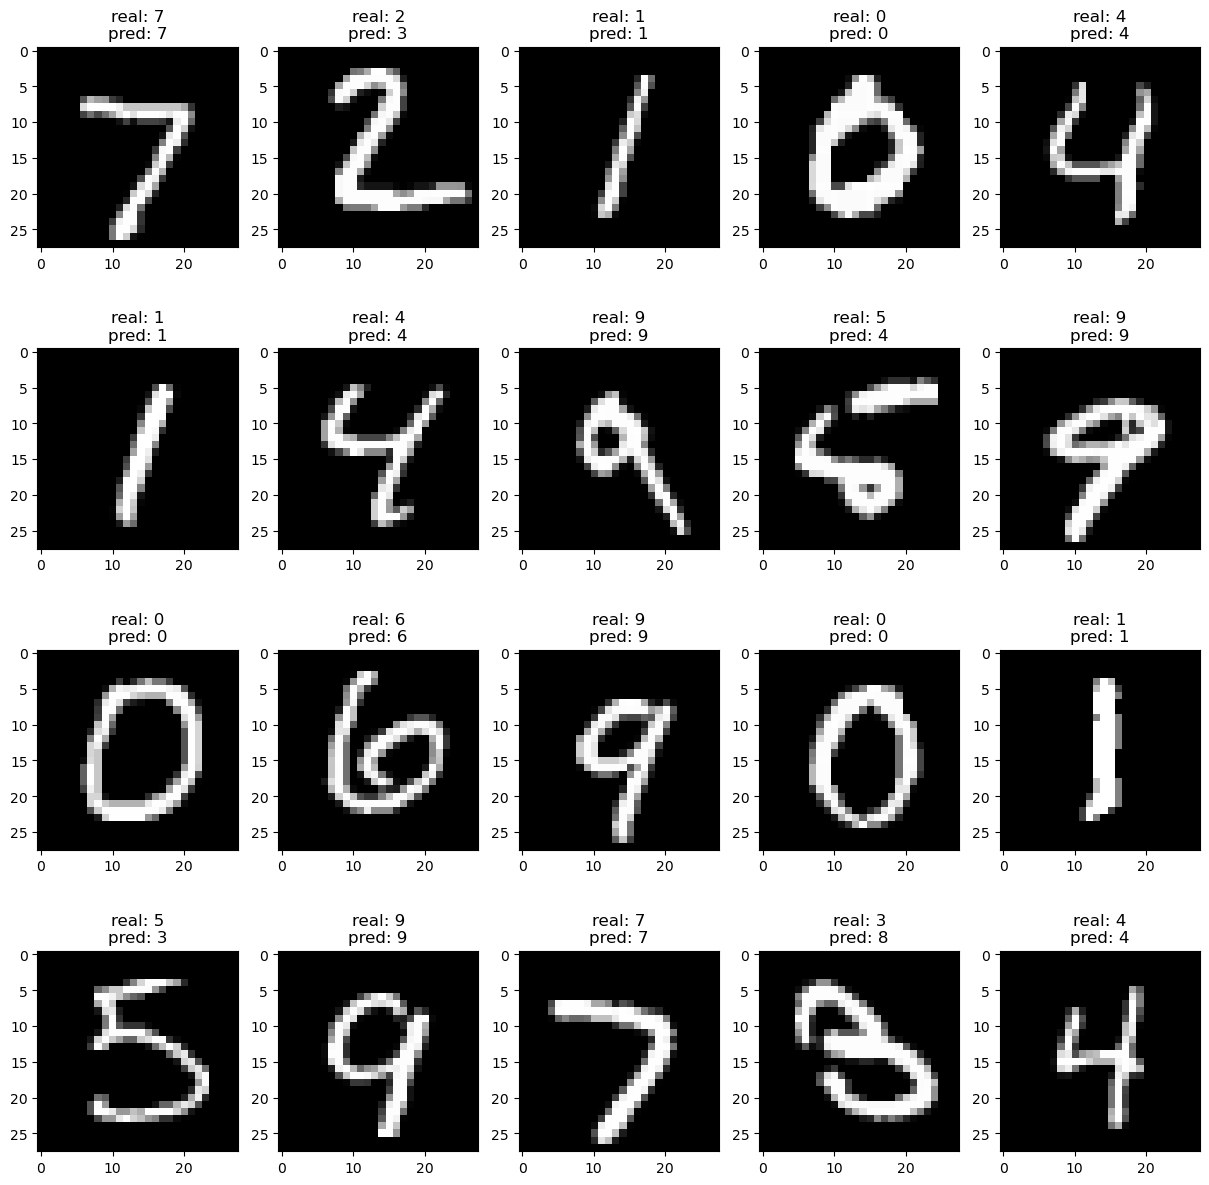

In [47]:
plt.figure(figsize=(15, 15))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(total_images[i].squeeze(), cmap='gray')
    plt.title(f'real: {total_labels[i]}\npred: {total_pred[i]}')

# LSTM model

In [48]:
class LSTM_model(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.lstm = torch.nn.LSTM(28, 128, batch_first=True)
        self.fc = torch.nn.Linear(128, 10)
        self.softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.squeeze()
        outputs, h_0 = self.lstm(x)
        outputs = self.fc(outputs[:, -1, :])
        outputs = self.softmax(outputs)

        return outputs

In [49]:
run_lstm = wandb.init(project='DL_mission_middle_2', name='lstm_training')
model = LSTM_model()

criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, 15, run_lstm)
run_lstm.finish()

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 1.9500262613097827, Train Accuracy: 0.3197083333333333, Valid Loss: 1.1499962309996288, Valid Accuracy: 0.63625


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.7501473209510247, Train Accuracy: 0.7725416666666667, Valid Loss: 0.49411413818597794, Valid Accuracy: 0.8545833333333334


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.384783573448658, Train Accuracy: 0.8863541666666667, Valid Loss: 0.3134942402442296, Valid Accuracy: 0.9086666666666666


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.2650970558946331, Train Accuracy: 0.9230625, Valid Loss: 0.25719384476542473, Valid Accuracy: 0.9208333333333333


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.2113545803974072, Train Accuracy: 0.93725, Valid Loss: 0.21463741858800253, Valid Accuracy: 0.9360833333333334


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.1751352228845159, Train Accuracy: 0.9480208333333333, Valid Loss: 0.18794801831245422, Valid Accuracy: 0.9450833333333334


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.15001871157437563, Train Accuracy: 0.9555833333333333, Valid Loss: 0.15161596114436784, Valid Accuracy: 0.9554166666666667


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.1283555032374958, Train Accuracy: 0.9618333333333333, Valid Loss: 0.1451482226451238, Valid Accuracy: 0.955


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.1130095268599689, Train Accuracy: 0.9660833333333333, Valid Loss: 0.12707841272155443, Valid Accuracy: 0.96175


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.10386304588367541, Train Accuracy: 0.968875, Valid Loss: 0.11813891120254993, Valid Accuracy: 0.96525


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.09153901304428776, Train Accuracy: 0.9729166666666667, Valid Loss: 0.1184406653046608, Valid Accuracy: 0.9648333333333333


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.08472734371510644, Train Accuracy: 0.9745833333333334, Valid Loss: 0.1136810053139925, Valid Accuracy: 0.9655833333333333


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.08117891405709088, Train Accuracy: 0.975375, Valid Loss: 0.10893909260630608, Valid Accuracy: 0.9668333333333333


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.07345733512192965, Train Accuracy: 0.9780833333333333, Valid Loss: 0.10033043349782626, Valid Accuracy: 0.9703333333333334


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0664055086672306, Train Accuracy: 0.9802708333333333, Valid Loss: 0.09773600660264492, Valid Accuracy: 0.9704166666666667


Train Accuracy,▁▆▇▇███████████
Train Loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁
Valid Accuracy,▁▆▇▇▇▇█████████
Valid Loss,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁
Train Accuracy,0.98027
Train Loss,0.06641
Valid Accuracy,0.97042
Valid Loss,0.09774


In [50]:
model.eval()
test_loss = 0.0
test_accuracy = 0

total_labels = []
total_images = []
total_pred = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        test_accuracy += (predicted == labels).sum().item()

        total_labels.extend(labels.cpu())
        total_images.extend(images.cpu())
        total_pred.extend(predicted.cpu())

test_loss = test_loss / len(test_dataloader)
test_accuracy = test_accuracy / len(test_dataset)

print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

  0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 0.08717434108257294, Test Accuracy: 0.975


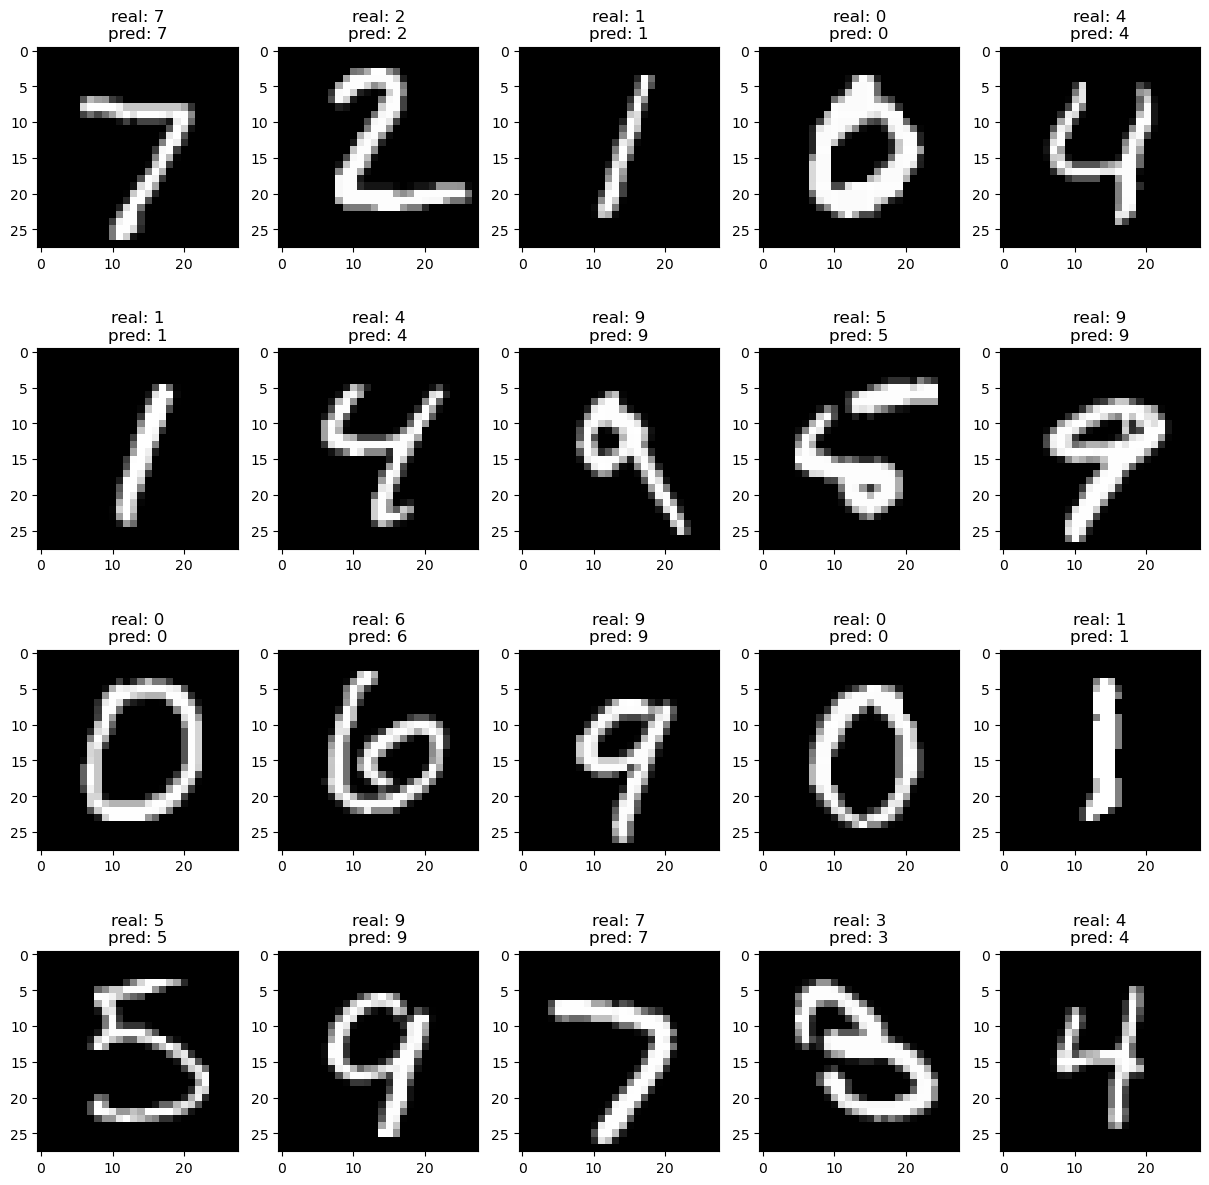

In [51]:
plt.figure(figsize=(15, 15))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(total_images[i].squeeze(), cmap='gray')
    plt.title(f'real: {total_labels[i]}\npred: {total_pred[i]}')

# GRU model

In [52]:
class GRU_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.gru = torch.nn.GRU(28, 128, batch_first=True)
        self.fc = torch.nn.Linear(128, 10)
        self.softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.squeeze()
        outputs, h_0 = self.gru(x)
        outputs = self.fc(h_0.squeeze())
        outputs = self.softmax(outputs)
        
        return outputs

In [53]:
run_gru = wandb.init(project='DL_mission_middle_2', name='gru_training')
model = LSTM_model()

criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, 15, run_gru)
run_gru.finish()

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 1.9385329981644948, Train Accuracy: 0.3315208333333333, Valid Loss: 1.1964417000611622, Valid Accuracy: 0.6154166666666666


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.7871857744952043, Train Accuracy: 0.7460208333333334, Valid Loss: 0.5268707871437073, Valid Accuracy: 0.84175


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.40416173574825126, Train Accuracy: 0.8797291666666667, Valid Loss: 0.33439265191555023, Valid Accuracy: 0.9024166666666666


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.2872479197879632, Train Accuracy: 0.9154166666666667, Valid Loss: 0.25814024979869526, Valid Accuracy: 0.9248333333333333


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.22217692838360867, Train Accuracy: 0.9352291666666667, Valid Loss: 0.2133837230503559, Valid Accuracy: 0.9381666666666667


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.18145739628622928, Train Accuracy: 0.9475, Valid Loss: 0.19287748138109842, Valid Accuracy: 0.94275


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.1601174334064126, Train Accuracy: 0.9528958333333334, Valid Loss: 0.18143259858091673, Valid Accuracy: 0.94425


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.13685672543942928, Train Accuracy: 0.9604166666666667, Valid Loss: 0.1556174543996652, Valid Accuracy: 0.9539166666666666


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.1259611427473525, Train Accuracy: 0.9624375, Valid Loss: 0.14502944176395735, Valid Accuracy: 0.9576666666666667


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.11936061456799507, Train Accuracy: 0.9644166666666667, Valid Loss: 0.1365001890808344, Valid Accuracy: 0.9591666666666666


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.10396294419964154, Train Accuracy: 0.9694166666666667, Valid Loss: 0.12010165614386399, Valid Accuracy: 0.96475


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.09257170317384104, Train Accuracy: 0.972875, Valid Loss: 0.11524041804174583, Valid Accuracy: 0.9654166666666667


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0877925028714041, Train Accuracy: 0.9741875, Valid Loss: 0.10741874513526757, Valid Accuracy: 0.969


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.08261565289770563, Train Accuracy: 0.9755625, Valid Loss: 0.10803898610174656, Valid Accuracy: 0.9666666666666667


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.07631598614777128, Train Accuracy: 0.976625, Valid Loss: 0.10120845151444276, Valid Accuracy: 0.96925


Train Accuracy,▁▅▇▇███████████
Train Loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁
Valid Accuracy,▁▅▇▇▇▇█████████
Valid Loss,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁
Train Accuracy,0.97662
Train Loss,0.07632
Valid Accuracy,0.96925
Valid Loss,0.10121


In [54]:
model.eval()
test_loss = 0.0
test_accuracy = 0

total_labels = []
total_images = []
total_pred = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        test_accuracy += (predicted == labels).sum().item()

        total_labels.extend(labels.cpu())
        total_images.extend(images.cpu())
        total_pred.extend(predicted.cpu())

test_loss = test_loss / len(test_dataloader)
test_accuracy = test_accuracy / len(test_dataset)

print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

  0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 0.10207678526639938, Test Accuracy: 0.9711


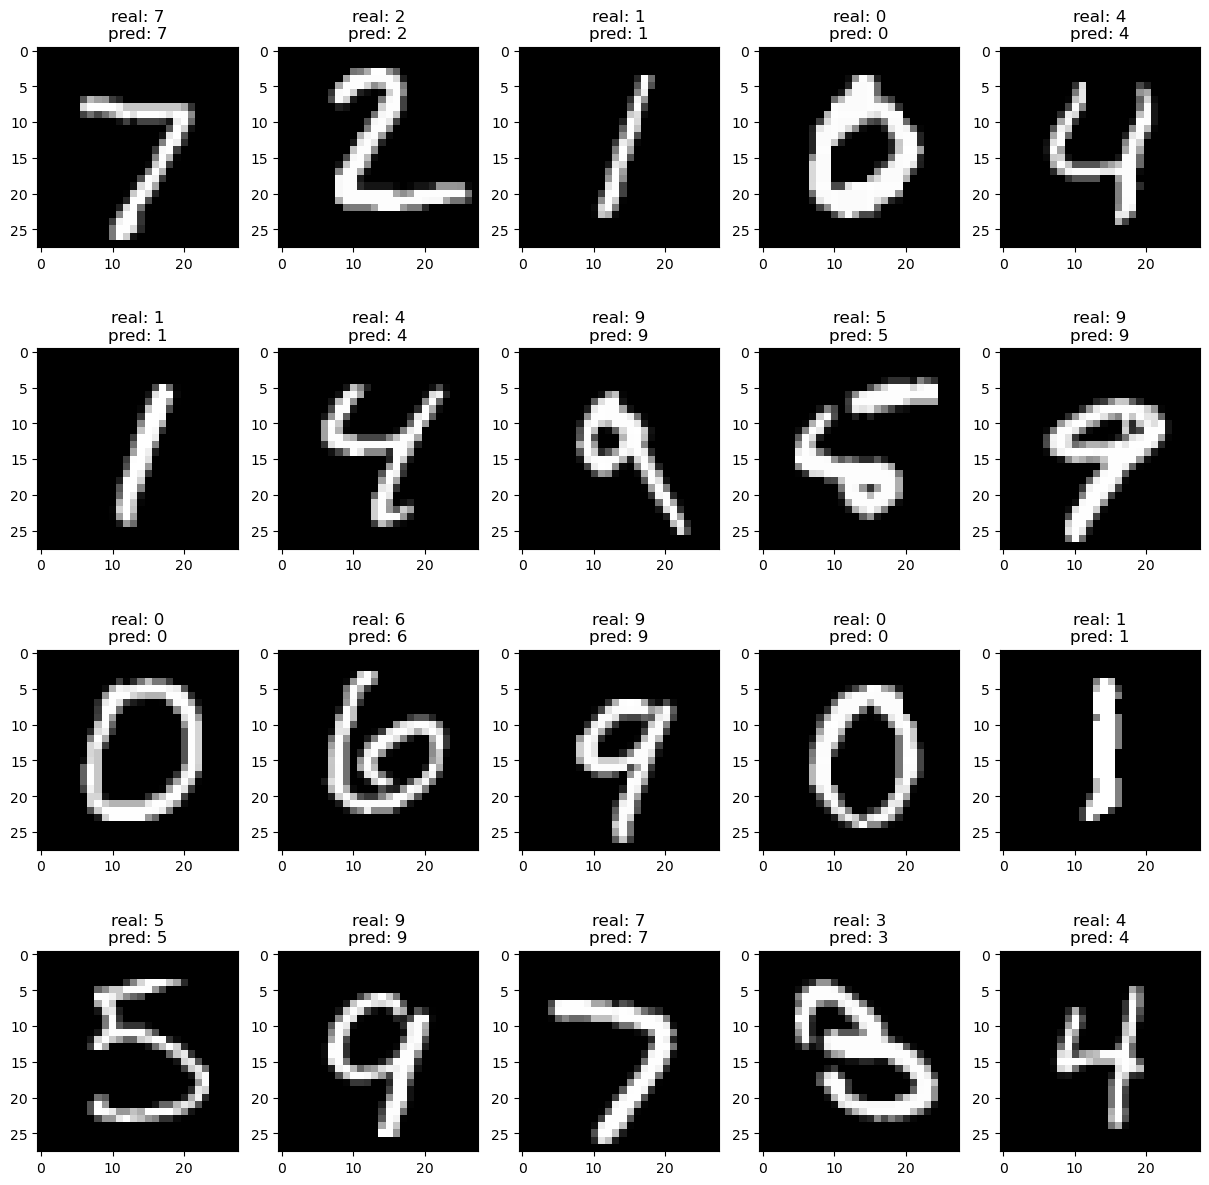

In [55]:
plt.figure(figsize=(15, 15))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(total_images[i].squeeze(), cmap='gray')
    plt.title(f'real: {total_labels[i]}\npred: {total_pred[i]}')